In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 
from signal_alignment import phase_align, chisqr_align
from scipy.interpolate import interp1d

### Function Definitions 

In [3]:
def cleaning_wave_df(DF):
    # dropping columns with no value
    #DF = DF.dropna(axis =1) 
    # dropping wave id column
    DF = DF.drop(columns = 2, axis =1)
    # name the first sensor columns 
    cols_0={0: "Time", 1: "FrameID", 3: "SensorID", 4: "Sensor_1Status", 5: "X_Nose", 6: "Y_Nose", 7:"Z_Nose"}
    DF = DF.rename(columns=cols_0, errors="raise")
    DF = DF.drop(columns = [8,9,10, 11], axis =1)
    
    DF = DF.drop(columns = [12,13,14,15,16,17,18,19,20], axis =1)
    cols_1={21: "SensorID", 22: "Sensor_2Status", 23: "X_LLeft", 24: "Y_LLeft", 25:"Z_LLeft"}
    DF = DF.rename(columns=cols_1, errors="raise")
    
    DF = DF.drop(columns = [26,27,28,29], axis =1)
    cols_2={30: "SensorID", 31: "Sensor_3Status", 32: "X_LR", 33: "Y_LR", 34:"Z_LR"}
    DF = DF.rename(columns=cols_2, errors="raise")
    
    DF = DF.drop(columns = [35,36,37,38], axis =1)
    cols_3={39: "SensorID", 40: "Sensor_4Status", 41: "X_UL", 42: "Y_UL", 43:"Z_UL"}
    DF = DF.rename(columns=cols_3, errors="raise")
    
    DF = DF.drop(columns = [44,45,46,47], axis =1)
    cols_4={48: "SensorID", 49: "Sensor_5Status", 50: "X_LL", 51: "Y_LL", 52:"Z_LL"}
    DF = DF.rename(columns=cols_4, errors="raise")
    
    DF = DF.drop(columns = [53,54,55,56], axis =1)
    cols_5={57: "SensorID", 58: "Sensor_6Status", 59: "X_JR", 60: "Y_JR", 61:"Z_JR"}
    DF = DF.rename(columns=cols_5, errors="raise")
    
    DF = DF.drop(columns = [62,63,64,65], axis =1)
    cols_6={66: "SensorID", 67: "Senson_7Status", 68: "X_JL", 69: "Y_JL", 70:"Z_JL"}
    DF = DF.rename(columns=cols_6, errors="raise")
    DF = DF.drop(columns = [71,72,73,74], axis =1)
    return DF

# cleaning video data 

def cleaning_video_df(DF):
    
    # choose the needed columns and convert the values to mm
    DF = DF[["BAG_Frame_number",'Time_Stamp (s)','Video_Frame_number',
             'landmark_48', 'landmark_48.1', 'landmark_48.2', 'landmark_54',
            'landmark_54.1', 'landmark_54.2', 'landmark_51', 'landmark_51.1',
            'landmark_51.2', 'landmark_57', 'landmark_57.1', 'landmark_57.2']]
  
    
    DF = DF.rename(columns={'Time_Stamp (s)': 'Time', "landmark_48": "X_LR", "landmark_48.1": "Y_LR",
                           "landmark_48.2": "Z_LR", "landmark_54": "X_LLeft",
                           "landmark_54.1": "Y_LLeft", "landmark_54.2": "Z_LLeft",
                           "landmark_51": "X_UL", "landmark_51.1": "Y_UL",
                           "landmark_51.2": "Z_UL", "landmark_57": "X_LL", "landmark_57.1": "Y_LL",
                           "landmark_57.2": "Z_LL"})
    
    DF = DF.astype({ "X_LR": np.double, "Y_LR": np.double,"Z_LR": np.double, "X_LLeft": np.double,
                            "Y_LLeft": np.double, "Z_LLeft": np.double, "X_UL": np.double,  "Y_UL": np.double,
                            "Z_UL": np.double,  "X_LL": np.double,  "Y_LL": np.double, "Z_LL": np.double})
    
    # conver the values from m to mm
    DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]] =  DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]]*1000
    return DF

def area_of_triangle(A,B,C):

    """
    computes the area of a triangle given by 3 points in 2d or 3d

    A, B and C must be numpy arrays

    it works with vectors A=[a1,a2,a3], B=[b1,b2,b3], c=[c1,c2,c3] or matrices

    A=[[a11,a12,a13],...[a1n,a2n,b3n]], B=[[b11,b12,b13],...[b1n,b2n,b3n]], C=[[c11,c12,c13],...[c1n,c2n,c3n]]

    """

    As = A.shape
    Bs = B.shape
    Cs = C.shape
   
    if len(As) == 1 :

        #we got vectors

        if (As[0]>3) or (Bs[0]>3) or (Cs[0]>3):

            raise Exception('coordinates can only be 2d or 3d')

            return None

    else:

        #check at least one of the dimensions is two or three
        if (As[0]==2) or (As[0]==3) or (As[1]==2) or (As[1]==3):

            #one of the dimensions of A is 2 or 3, now check that all the vectors have the same size
            if (As!=Bs) or (As!=Cs):

                raise Exception('vectors must be the same size')
                return None

            else:
                #move forward
                pass

        else:

            raise Exception('coordinates can only be 2d or 3d')

            return None

    #at this point we know that one of the dimensions has 2 or 3 elements we move forward assuming that
    #the user provided the vectors with the correct size
    #move all vectors to the same origin

    AB = B-A
    AC = C-A  

    if len(As) == 1 :

        #if only one vector the simply compute the norm of the cross product
        area = (1/2)*np.linalg.norm(np.cross(AB,AC))

    else:

        #if only multiple vectors compute the norm along the axis one
        area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)   

    return area

def lipDist(DF):
    
    # Assumes columns are named in a particular way 
    
    DF['Horiz_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_LLeft - row.X_LR)**2 + (row.Y_LLeft - row.Y_LR)**2
                                                                  + (row.Z_LLeft - row.Z_LR)**2), axis = 1) 
    DF['Vert_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_UL - row.X_LL)**2 + (row.Y_UL - row.Y_LL)**2 +
                                                                 (row.Z_UL - row.Z_LL)**2), axis = 1)
    return DF

In [4]:
# Signal Processing

# sampling frequency set to 100 HZ
fsample = 100

def sig_shift(signal, amount):
    length = len(signal)    
    shifted = np.zeros(length+amount - 1)
    shifted[:amount-1] = 0
    shifted[amount-1:] = signal[:]
    return shifted

def sig_norm(signal):
    signal_mean = np.mean(signal)
    signal_normalised = signal - signal_mean
    return signal_normalised

# Butterworth filter 8-order, 15hz cutoff
fc = 15
w = fc / (fsample/2)
b , a = signal.butter(8, w, btype ='lowpass')

### Reading, Cleaning, and Preprocessing DATA

In [5]:
Tasks = ['REST', 'OPEN', 'SPREAD', 'OOEE', 'PA', 'BBP', 'TNG_PROTRUSION', 'TNG_LAT', 'TNG_NOSE']
Conditions = ['FAST', 'SLOW', 'DIS', 'HOLD', 'NORM']

TASK_DFS_VIDEO_LIST = list()
TASK_DFS_WAVE_LIST = list()

In [6]:
# choose a task to do the analysis on,for example open, spread, pa, bbp, etc
Task = Tasks[1]

In [7]:
#####   WAVE DATA   ######

# read the wave data files of the chosen task into dfs and store them all in a list 
path_w = r'C:\Users\jafarid\Documents\Code\ValidationStudy\wave_data'
ext_w=('.tsv')
Files_w = os.listdir(path_w)           
Files_w = [i for i in Files_w if i.endswith(ext_w)]

for i in range(0, len(Files_w)):
    # choose which task to focus on 
    if Task in Files_w[i]:
        df = pd.read_csv(path_w+ "\\" + Files_w[i], delimiter='\t', skiprows=1,header=None)
        df = cleaning_wave_df(df)
        # depending on the file we are reading the indexing below needs to change 
        #if Files_w[i][20:-4] == 'EN_HOLD_1' or Files_w[i][20:-4] == 'EN_HOLD':
        #    df['FileName'] = Files_w[i][18:-4]
        
        #else: 
        df['FileName'] = Files_w[i][18:-4]
        df['PatientID'] = Files_w[i][:2]
        df['DataDATE'] = Files_w[i][5:13]
        df['Task'] = Task
        for condition in Conditions:
            if condition in Files_w[i]:
                df['Condition'] = condition

            else:
                df['Condition'] = 'NORMAL'
                
   
        # preprocessing, using the cubic interpolation to fill in the missing data 
        df = df.interpolate(method ='cubic', limit_direction ='forward') 
        df = lipDist(df)

        #left_area = area_of_triangle(df[["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
        #                               df[["X_LL", "Y_LL", "Z_LL"]].values)
        #df['Area_Left'] = np.array(left_area)
        #right_area = area_of_triangle(df[["X_LR", "Y_LR","Z_LR"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
        #                                df[[ "X_LL", "Y_LL", "Z_LL"]].values)
        #df['Area_Right'] =  np.array(right_area)        
        #df["Area_Ratio"] = df.apply(lambda row: row.Area_Left/row.Area_Right, axis = 1)
        
        # Gaussian filter
        df['Vert_Lip_Motion_F1']= gaussian_filter(df['Vert_Lip_Motion'], sigma=7)
        df['Horiz_Lip_Motion_F1']= gaussian_filter(df['Horiz_Lip_Motion'], sigma=7)
        df["Speed_F1"] = gaussian_filter(np.gradient(df['Vert_Lip_Motion'], df["Time"]), 3)
        
        # Butterworth filter 8-order, 15hz cutoff
        df['Vert_Lip_Motion_F2']= signal.filtfilt(b, a, df['Vert_Lip_Motion'])
        df['Horiz_Lip_Motion_F2']= signal.filtfilt(b, a, df['Horiz_Lip_Motion'])
        df["Speed_F2"] = signal.filtfilt(b, a, np.gradient(df['Vert_Lip_Motion'], df["Time"]))
        
        TASK_DFS_WAVE_LIST.append(df)
        
        print(Files_w[i][:2],Files_w[i][18:-4])
        print()

    


DJ OPEN_HOLD

DJ OPEN_NORMAL

DJ OPEN_DIS

DJ OPEN_FAST

MK OPEN_HOLD

MK OPEN_NORMAL

MK OPEN_DIS

MK OPEN_FAST

RM OPEN_HOLD

RM OPEN_NORM

RM OPEN_DIS

RM OPEN_FAST



In [8]:
if 0:
    %matplotlib qt
    plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion'],'b')
    plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion_F1'],'g')
    plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion_F2'],'r')

In [9]:
#####   VIDEO DATA   ######

# read the wave data files of the chosen task into dfs and store them all in a list 
path_v = r'C:\Users\jafarid\Documents\Code\ValidationStudy\video_data_processed'
ext_v=('_Landmarks3D.csv')
Files_v = os.listdir(path_v)           
Files_v = [i for i in Files_v if i.endswith(ext_v)]

for i in range(0, len(Files_v)):
    # choose which task to focus on 
    if Task in Files_v[i]:
        df = pd.read_csv(path_v+ "\\" + Files_v[i])
        df =  df.drop([0]) 
        df = cleaning_video_df(df)
        # depending on the file we are reading the indexing below needs to change 
        df['FileName'] = Files_v[i][12:-16]
        df['PatientID'] = Files_v[i][:2]
        #df['DataDATE'] = Files_v[i][5:13]
        df['Task'] = Task
        for condition in Conditions:
            if condition in Files_v[i]:
                df['Condition'] = condition

            else:
                df['Condition'] = 'NORMAL'
                

        # preprocessing, using the cubic interpolation to fill in the missing data 
        df = df.interpolate(method ='cubic', limit_direction ='forward') 
        df = lipDist(df)

        #left_area = area_of_triangle(df[["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
        #                               df[["X_LL", "Y_LL", "Z_LL"]].values)
        #df['Area_Left'] = np.array(left_area)
        #right_area = area_of_triangle(df[["X_LR", "Y_LR","Z_LR"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
        #                                df[[ "X_LL", "Y_LL", "Z_LL"]].values)
        #df['Area_Right'] =  np.array(right_area)        
        #df["Area_Ratio"] = df.apply(lambda row: row.Area_Left/row.Area_Right, axis = 1)
        df['Vert_Lip_Motion_F1']= gaussian_filter(df['Vert_Lip_Motion'], sigma=3)
        df['Horiz_Lip_Motion_F1']= gaussian_filter(df['Horiz_Lip_Motion'], sigma=3)
        df["Speed_F1"] = gaussian_filter(np.gradient(df['Vert_Lip_Motion_F1'], df["Time"]), 3)
        TASK_DFS_VIDEO_LIST.append(df)
        print(Files_v[i][12:-16])

    


OPEN_DIS
OPEN_FAST
OPEN_HOLD
OPEN_NORM
OPEN_DIS
OPEN_FAST
OPEN_HOLD
OPEN_NORM
OPEN_DIS
OPEN_FAST
OPEN_HOLD
OPEN_NORMAL


In [10]:

TASK_DFS_WAVE_100HZ_LIST = list()


In [11]:
# RESAMPLING TO 100Hz for the wave data

for DF_WAVE in TASK_DFS_WAVE_LIST:
    WAVE_100HZ = pd.DataFrame()
    tmax = len(DF_WAVE.Time) - 1
    tmax_value = DF_WAVE.Time[tmax]
    tmin_value = DF_WAVE.Time[0]
    nsample = fsample*(tmax_value - tmin_value)
    perfect_time = np.linspace(tmin_value, tmax_value, num= nsample, endpoint=True)
    WAVE_100HZ['Time'] = perfect_time
    f_motion = interp1d(DF_WAVE.Time, DF_WAVE['Vert_Lip_Motion_F2'], kind = 'linear')
    WAVE_100HZ['Vert_Lip_Motion'] = f_motion(perfect_time)
    f_speed = interp1d(DF_WAVE.Time, DF_WAVE['Speed_F1'], kind = 'linear')
    WAVE_100HZ['Speed'] = f_speed(perfect_time)
    WAVE_100HZ['FileName'] = DF_WAVE['FileName'][1]
    WAVE_100HZ['PatientID'] = DF_WAVE['PatientID'][1]
    TASK_DFS_WAVE_100HZ_LIST.append(WAVE_100HZ)
    #print(len(DF_WAVE['Vert_Lip_Motion_F1']))
    #print(len(WAVE_100HZ['Vert_Lip_Motion']))
    #print()

C:\Users\jafarid\AppData\Local\Continuum\anaconda3\envs\opecvpytorch_env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


In [12]:
TASK_DFS_VIDEO_100HZ_LIST = list()

In [13]:
# Upsampling to 100Hz for the video data
for DF_VIDEO in TASK_DFS_VIDEO_LIST:
    WAVE_100HZ = pd.DataFrame()
    tmax = len(DF_VIDEO.Time) - 1
    tmax_value = DF_VIDEO.Time[tmax]
    tmin_value = DF_VIDEO.Time[1]
    nsample = fsample*(tmax_value - tmin_value)
    perfect_time = np.linspace(tmin_value, tmax_value, num= nsample, endpoint=True)
    WAVE_100HZ['Time'] = perfect_time
    f_motion = interp1d(DF_VIDEO.Time, DF_VIDEO['Vert_Lip_Motion_F1'], kind = 'linear')
    WAVE_100HZ['Vert_Lip_Motion'] = f_motion(perfect_time)
    f_speed = interp1d(DF_VIDEO.Time, DF_VIDEO['Speed_F1'], kind = 'linear')
    WAVE_100HZ['Speed'] = f_speed(perfect_time)
    WAVE_100HZ['FileName'] = DF_VIDEO['FileName'][1]
    WAVE_100HZ['PatientID'] = DF_VIDEO['PatientID'][1]
    TASK_DFS_VIDEO_100HZ_LIST.append(WAVE_100HZ)

C:\Users\jafarid\AppData\Local\Continuum\anaconda3\envs\opecvpytorch_env\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


OPEN_HOLD
Wave index:0
Video index:2
The phase shift is:165.59

OPEN_DIS
Wave index:2
Video index:0
The phase shift is:161.3

OPEN_FAST
Wave index:3
Video index:1
The phase shift is:90.44

OPEN_HOLD
Wave index:4
Video index:6
The phase shift is:202.02

OPEN_DIS
Wave index:6
Video index:4
The phase shift is:219.99

OPEN_FAST
Wave index:7
Video index:5
The phase shift is:198.69

OPEN_HOLD
Wave index:8
Video index:10
The phase shift is:146.96

OPEN_DIS
Wave index:10
Video index:8


C:\Users\jafarid\AppData\Local\Continuum\anaconda3\envs\opecvpytorch_env\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


The phase shift is:250.54

OPEN_FAST
Wave index:11
Video index:9


C:\Users\jafarid\AppData\Local\Continuum\anaconda3\envs\opecvpytorch_env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\jafarid\AppData\Local\Continuum\anaconda3\envs\opecvpytorch_env\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


The phase shift is:195.33



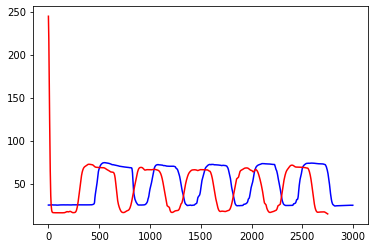

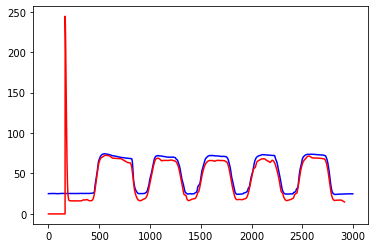

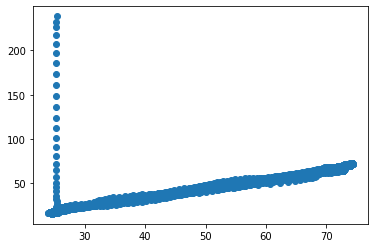

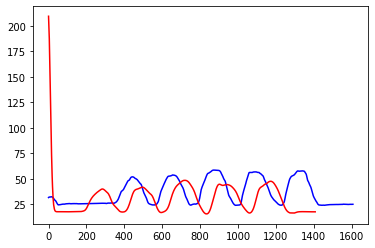

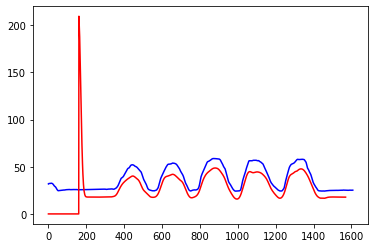

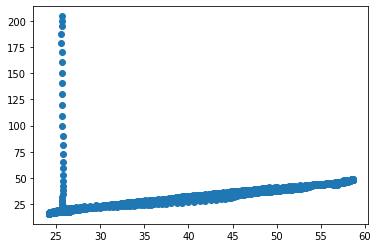

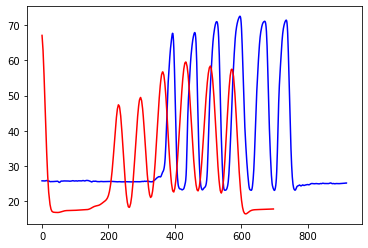

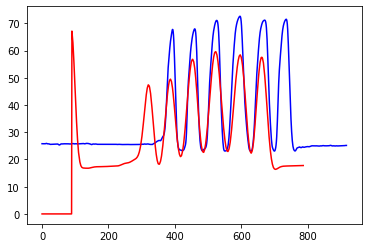

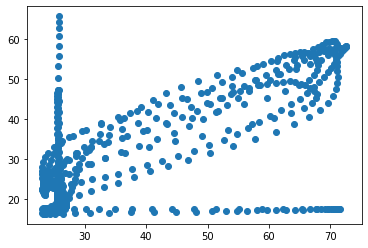

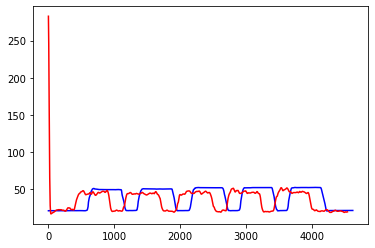

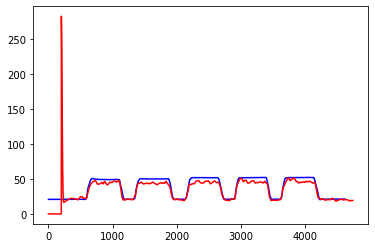

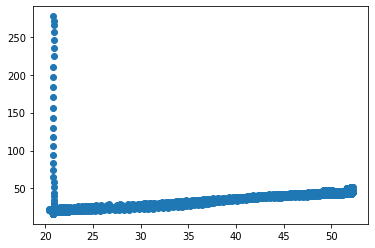

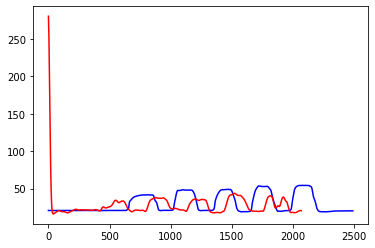

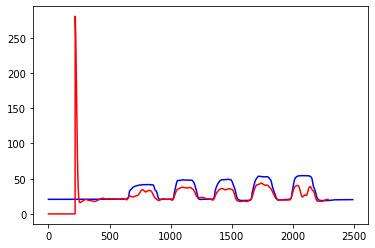

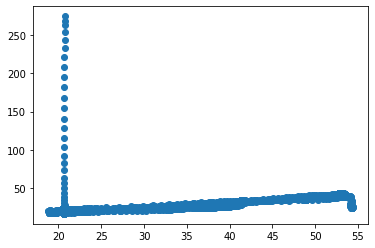

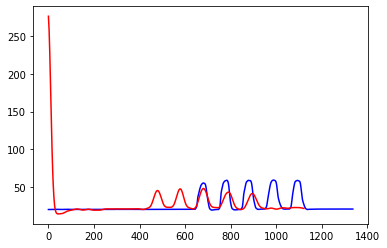

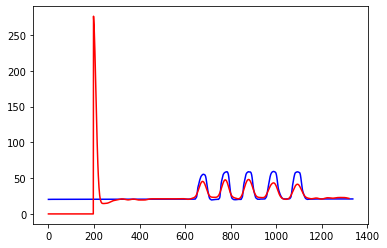

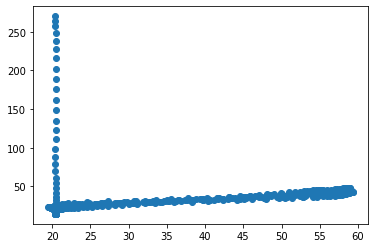

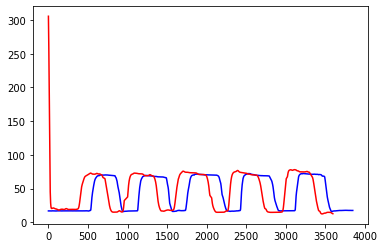

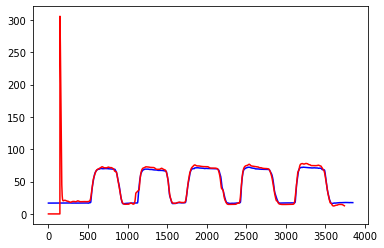

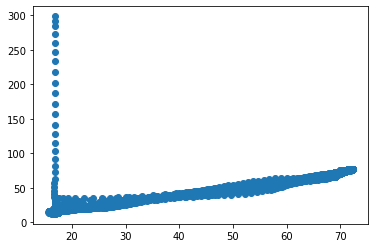

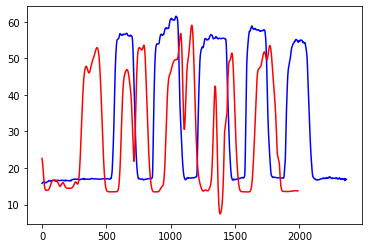

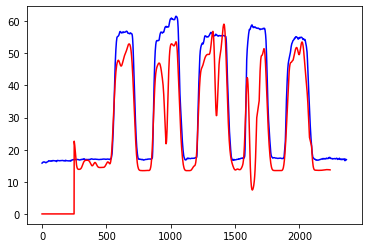

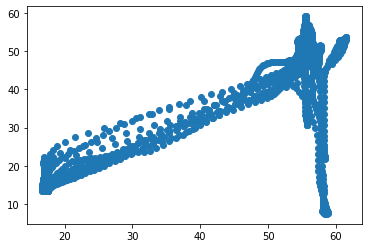

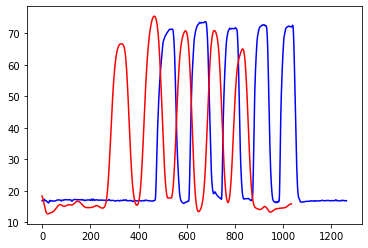

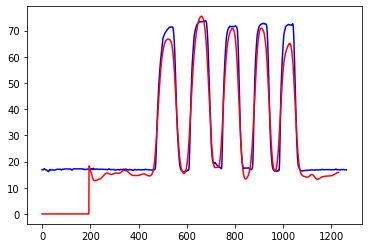

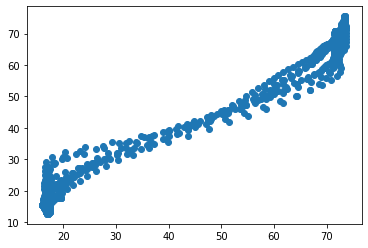

In [14]:
for i in range(len(TASK_DFS_WAVE_100HZ_LIST)):
    for j in range(len(TASK_DFS_VIDEO_100HZ_LIST)):
        
        if TASK_DFS_WAVE_100HZ_LIST[i]['PatientID'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['PatientID'][1]:
        
            if TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1]== TASK_DFS_VIDEO_100HZ_LIST[j]['FileName'][1]:
                print(TASK_DFS_WAVE_100HZ_LIST[i]['FileName'][1])
                print('Wave index:{}'.format(i))
                print('Video index:{}'.format(j))

                video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'])
                wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'])

                upper_bound = len(video_n) - 10

                s = phase_align(wave_n, video_n, [5,upper_bound])
                print('The phase shift is:{}'.format(s))

                sp = math.ceil(s)


                video_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'],sp)

                if len(video_shifted) <= len(wave_n):
                    signal_bound = upper_bound + sp
                else: 
                    signal_bound = len(wave_n) - 10 

                print()
                plt.figure()

                plt.plot(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'],'b')
                plt.plot(TASK_DFS_VIDEO_100HZ_LIST[j]['Vert_Lip_Motion'],'r')
                #plt.legend()
                #plt.figure()
                #a = np.gradient(TASK_DFS_WAVE_100HZ_LIST[i]['Time'])
                #plt.plot(a, 'b')
                #b = np.gradient(TASK_DFS_VIDEO_100HZ_LIST[j]['Time'])
                #plt.plot(b, 'r')

                plt.figure()
                plt.plot(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'],'b')
                plt.plot(video_shifted,'r')
                #plt.legend()

                plt.figure()
                plt.scatter(TASK_DFS_WAVE_100HZ_LIST[i]['Vert_Lip_Motion'][sp:signal_bound], 
                            video_shifted[sp:signal_bound])



The phase shift is:215.0



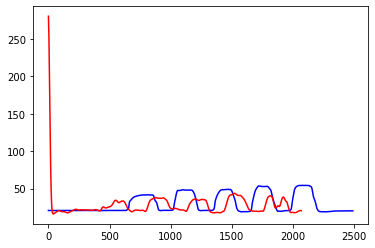

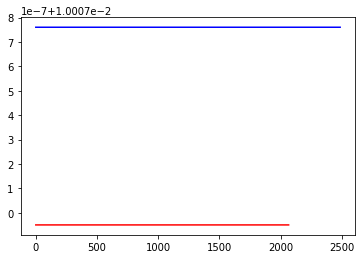

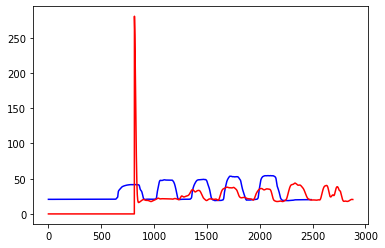

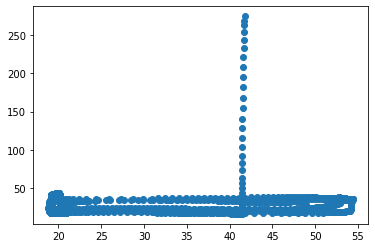

In [15]:
video_n = sig_norm(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'])
wave_n = sig_norm(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'])

upper_bound = len(video_n) - 10
upper_bound2 = len(wave_n) - 10

s = phase_align(wave_n[600:1100], video_n, [10,upper_bound])
print('The phase shift is:{}'.format(s))

sp = math.ceil(s) + 600


video_shifted = sig_shift(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'],sp)

if len(video_shifted) <= len(wave_n):
    signal_bound = upper_bound + sp
else: 
    signal_bound = len(wave_n) - 10 

print()
plt.figure()

plt.plot(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'],'b')
plt.plot(TASK_DFS_VIDEO_100HZ_LIST[4]['Vert_Lip_Motion'],'r')

plt.figure()
a = np.gradient(TASK_DFS_WAVE_100HZ_LIST[6]['Time'])
plt.plot(a, 'b')
b = np.gradient(TASK_DFS_VIDEO_100HZ_LIST[4]['Time'])
plt.plot(b, 'r')

plt.figure()
plt.plot(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'],'b')
plt.plot(video_shifted,'r')

plt.figure()
plt.scatter(TASK_DFS_WAVE_100HZ_LIST[6]['Vert_Lip_Motion'][sp:signal_bound], 
            video_shifted[sp:signal_bound])


In [16]:
%matplotlib qt
plt.plot(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion'],'o')
plt.plot(TASK_DFS_WAVE_100HZ_LIST[3]['Vert_Lip_Motion'])

In [17]:
plt.plot(TASK_DFS_WAVE_100HZ_LIST[3]['Vert_Lip_Motion'],'o')

In [18]:

path_v = r'C:\Users\jafarid\Documents\Code\ValidationStudy\video_data_processed'
ext_v=('_Landmarks3D.csv')
Files_v = os.listdir(path_v)           
Files_v = [i for i in Files_v if i.endswith(ext_v)]

for i in range(0, len(Files_v)):
    print(Files_v[i][12:-16])
print(len(Files_w))

NORMAL
SLOW
PA_FAST
PA_NORM
BIGSMILE_HOLD
BIGSMILE_NORM
OOEE_NORM
OOEE_SLOW
OPEN_DIS
OPEN_FAST
OPEN_HOLD
OPEN_NORM
SPREAD_HOLD
SPREAD_NORM
REST
NORMAL
SLOW
PA_FAST
PA_NORM
BIGSMILE_HOLD
BIGSMILE_NORM
OOEE_NORM
OOEE_SLOW
OPEN_DIS
OPEN_FAST
OPEN_HOLD
OPEN_NORM
SPREAD_HOLD
SPREAD_NORM
REST
NORMAL
SLOW
PA_FAST
PA_NORMAL
BIGSMILE_HOLD
BIGSMILE_NORMAL
OOEE_NORMAL
OOEE_SLOW
OPEN_DIS
OPEN_FAST
OPEN_HOLD
OPEN_NORMAL
SPREAD_HOLD
SPREAD_NORMAL
REST
45
